In [2]:
import torch
import numpy as np
from mmengine.config import Config
from mmengine.runner import load_state_dict
from mmdet.registry import MODELS
from mmdet.utils import register_all_modules
from mmengine.logging import HistoryBuffer

# 🔐 Safely allow PyTorch to load necessary pickled objects

torch.serialization.add_safe_globals([
    HistoryBuffer,
    np.core.multiarray._reconstruct,
    np.ndarray,
    np.dtype,
    np.float64().dtype.__class__,  # Float64DType
    np.int64().dtype.__class__,    # ✅ NEW: Int64DType
])

# 🔧 Config and checkpoint paths
config_file = '/Users/jbm/Documents/DSAN_6500/WatchdogAI/htc_r50_artifact_final/htc_r50_fpn_1x_artifact.py'
checkpoint_file = '/Users/jbm/Documents/DSAN_6500/WatchdogAI/htc_r50_artifact_final/best_coco_bbox_mAP_epoch_11.pth'

# 🔄 Register MMDetection modules
register_all_modules()

# 📄 Load config and remove pretrained if present
cfg = Config.fromfile(config_file)
cfg.model.pop('pretrained', None)

# 🏗️ Build model
model = MODELS.build(cfg.model)
model.eval()

# 🧠 Load checkpoint (safely)

ckpt = torch.load(
    checkpoint_file,
    map_location='cpu',
    weights_only=False  # Only use if you trust the checkpoint source!
)

state_dict = ckpt['state_dict'] if 'state_dict' in ckpt else ckpt
load_state_dict(model, state_dict)

# 📊 Total parameter count
total_params = sum(p.numel() for p in model.parameters())
print(f"\n✅ Total Parameters: {total_params:,} ({total_params / 1e6:.2f}M)\n")

# 📦 Per-module parameter count
for name, module in model.named_children():
    module_params = sum(p.numel() for p in module.parameters())
    print(f"{name}: {module_params:,} ({module_params / 1e6:.2f}M)")



✅ Total Parameters: 69,151,841 (69.15M)

data_preprocessor: 0 (0.00M)
backbone: 23,508,032 (23.51M)
neck: 3,344,384 (3.34M)
rpn_head: 593,935 (0.59M)
roi_head: 41,705,490 (41.71M)


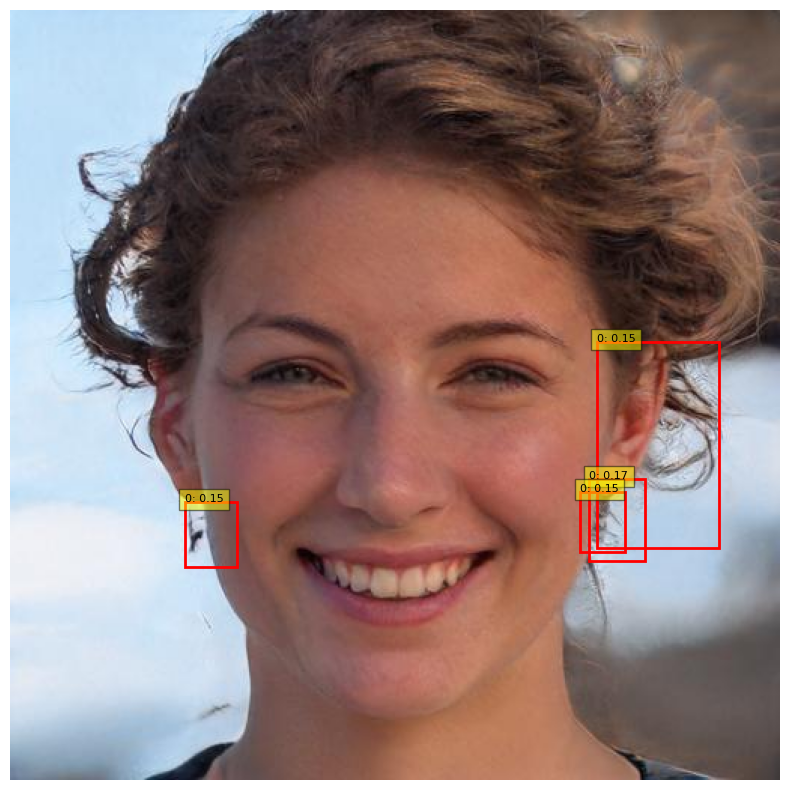

✅ 4 object(s) detected with confidence > 0.5.


In [23]:
import torch
import matplotlib.pyplot as plt
import mmcv
from mmengine.structures import InstanceData
from mmdet.structures import DetDataSample
from mmcv.transforms import Compose
from mmengine.dataset import pseudo_collate  # ✅ THIS IS THE CORRECT COLLATE FUNCTION

detection_threshold = 0.15

# 📥 Load image
image_path = '/Users/jbm/Documents/DSAN_6500/WatchdogAI/data_artifacts/test/28426_png.rf.72843796a9a02f41eda03a6efcb7f981.jpg'
image = mmcv.imread(image_path)  # mmcv loads in BGR

# 🛠️ Build the test pipeline from config
test_pipeline = cfg.test_dataloader.dataset.pipeline
pipeline = Compose(test_pipeline)

# Prepare the input manually
data = dict(img=image, img_path=image_path)

# Apply the pipeline (resize, normalize, tensorize, etc.)
data = pipeline(data)

# ✅ Correct collate function
data = pseudo_collate([data])  # <<< this is what dataloaders do automatically

# 🔮 Inference
with torch.no_grad():
    result = model.test_step(data)

# 📦 Extract prediction
pred = result[0]

bboxes = pred.pred_instances.bboxes.cpu().numpy()
labels = pred.pred_instances.labels.cpu().numpy()
scores = pred.pred_instances.scores.cpu().numpy()

# 📈 Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mmcv.bgr2rgb(image))  # Your original image is still BGR!
ax.axis('off')

# ✅ Get class names
class_names = model.dataset_meta['classes'] if hasattr(model, 'dataset_meta') else None

# ✅ Detection counter
detections_found = 0

for bbox, label, score in zip(bboxes, labels, scores):
    if score < detection_threshold:
        continue
    detections_found += 1
    x1, y1, x2, y2 = bbox
    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                               fill=False, edgecolor='red', linewidth=2))
    label_text = f"{class_names[label]}: {score:.2f}" if class_names else f"{label}: {score:.2f}"
    ax.text(x1, y1, label_text,
            bbox=dict(facecolor='yellow', alpha=0.5), fontsize=8, color='black')

plt.show()

# 🛎️ Print detection result
if detections_found == 0:
    print("🚫 No objects detected with confidence > 0.5.")
else:
    print(f"✅ {detections_found} object(s) detected with confidence > 0.5.")
